In [5]:
#############################################################################
## Ce code représente un exemple de prédictions avec des valeurs au
## hasard et les valeurs attendues
#############################################################################

library(Matrix)
library(RCurl)
u.data <- read.csv('u.data.csv', sep='|', header=T)
head(u.data)
m <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m) <- paste('u', 1:nrow(m), sep='')
colnames(m) <- paste('i', 1:ncol(m), sep='')
m <- as.matrix(m)
## m est u.data
m.na <- m
m.na[m==0] <- NA
############################################################################
### Votes au hasard
m.hasard <- m.na
m.hasard[m>0] <- sample(m.hasard[m>0], sum(m>0))
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)
mae(m.hasard, m.na)
0

Loading required package: bitops


user.id,item.id,rating,timestamp
196,242,3,881250949
186,302,3,891717742
22,377,1,878887116
244,51,2,880606923
166,346,1,886397596
298,474,4,884182806


[1] 1.23382

[1] 0

In [47]:
# Question 2
# Normalisation
## Calcul des votes moyens
votes.utilisateurs.moyen <- rowMeans(m.na, na.rm=T)
votes.items.moyen <- colMeans(m.na, na.rm=T)
## Utilitaires
`%-=%` = function(e1,e2) eval.parent(substitute(e1 <- e1 - e2))
`%+=%` = function(e1,e2) eval.parent(substitute(e1 <- e1 + e2))
## Remplacement des NA par les votes moyens sur les items correspondants
indx <- is.na(t(m.na))
m.filled <- t(m.na)
m.filled[indx] <- votes.items.moyen[col(m.filled)][indx]
m.filled <- t(m.filled)
## Normalisation en soustrayant les votes moyens des utilisateurs correspondants
m.filled[,1:ncol(m)] %-=% votes.utilisateurs.moyen
# SVD
m.svd <- svd(m.filled)

[[1]]
[1] 5

In [48]:
# Question 5
# Matrices U, S et V
U <- m.svd$u
S <- diag(m.svd$d)
V <- m.svd$v
# Matrices Sk
compute.Sk <- function(k){
    return(diag(m.svd$d[1:k]))
}
list.Sk <- list()
aux <- c(2,5:21,25,50,100)
list.Sk <- lapply(aux, compute.Sk)
length(list.Sk)

[1] 21

In [49]:
# Racine carrée de chaque Sk
# Note : diag n'est pas une opération très efficace.
list.Sk.roots <- lapply(list.Sk, function(x) diag(sqrt(diag(x))))

In [101]:
# Uk*Sk^1/2 et Sk^1/2*Vk
list.Uk <- lapply(aux, function(k) U[,1:k])
list.Vk <- lapply(aux, function(k) V[,1:k])
list.UkSk <- mapply(function(M,N) M%*%N, list.Uk, list.Sk.roots)
list.SkVk <- mapply(function(M,N) M%*%t(N), list.Sk.roots, list.Vk)
# UkSkVk'
list.UkSkVk <- list()
list.UkSkVk <- mapply(function(M,N) M%*%N, list.UkSk, list.SkVk, SIMPLIFY=F)
# Dénormalisation
tmp <- 1:21
P <- lapply(tmp, function(k) {list.UkSkVk[[k]][,1:1682] %+=% votes.utilisateurs.moyen; list.UkSkVk[[k]]})

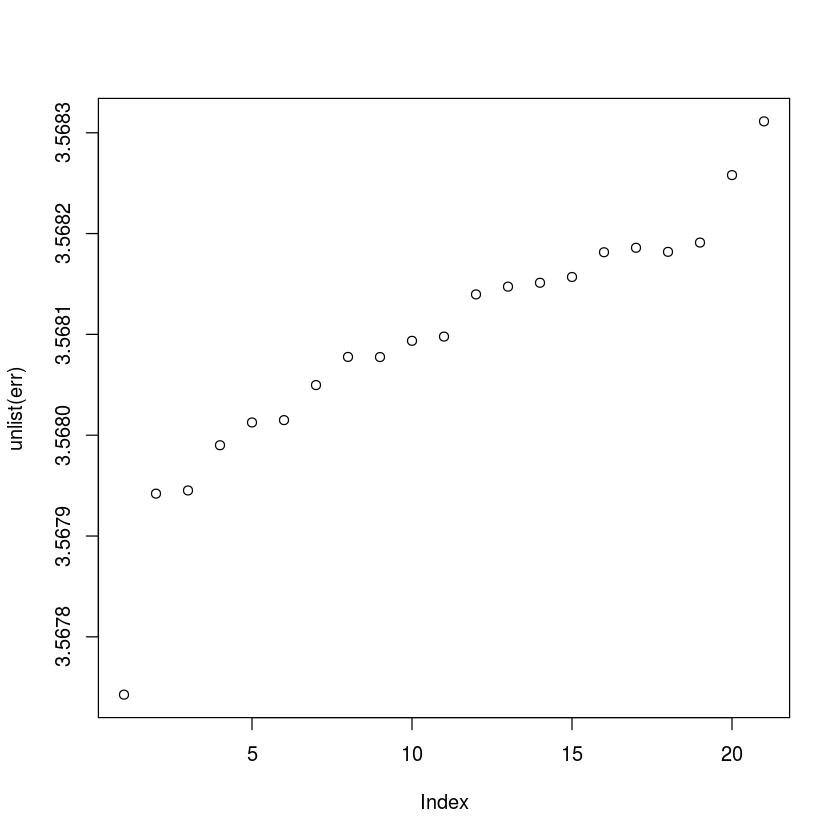

In [118]:
# Prediction (MAE)
votes.attendus <- outer(votes.utilisateurs.moyen, votes.items.moyen, FUN='+')/2# pas sûre du tout qu'on doive comparer à ça
err <- lapply(tmp, function(k) mae(votes.attendus, P[[k]]))
plot(unlist(err))
# d'autant que comme ça on a une erreur strictement croissante selon le nombre de dimensions, pareil avec m.hasard
# ce qui est normal : on compare à la moyenne ; moins on a de dimensions, moins on a de détails, moins on a d'écart à la moyenne
# mais ça ne nous apporte pas l'information nécessaire pour trouver la dimension idéale

[1] 6

m.na.train
    1     2     3     4     5 
 5062  9470 22479 28405 17695 

[1] NaN

[1] 21

[1] 3.589529

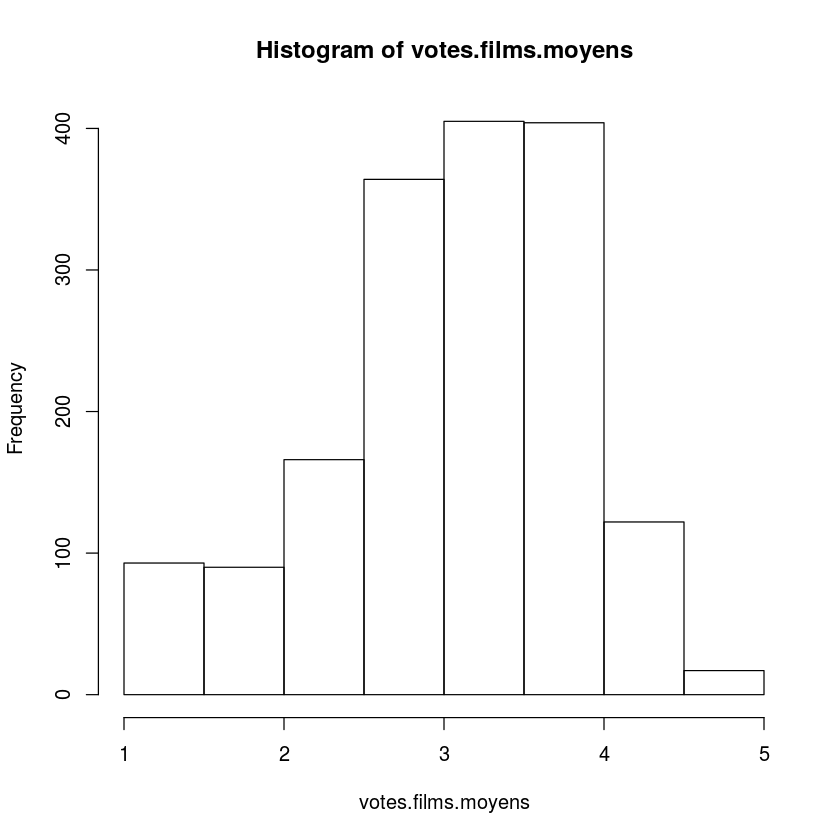

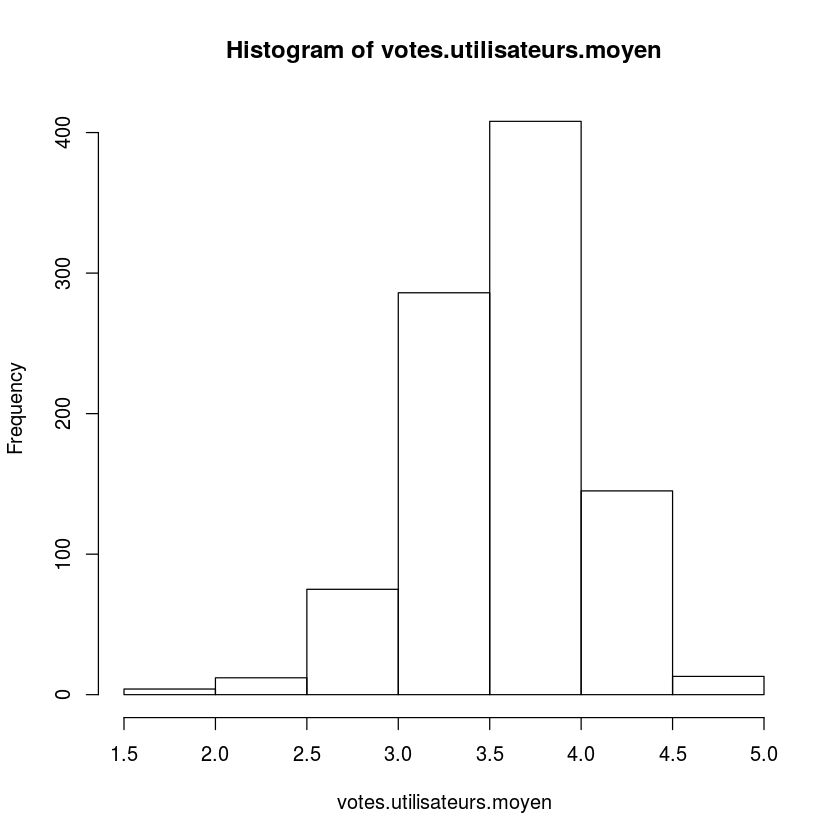

[1] 0.477316

[1] 0.477316

[1] 0.567766

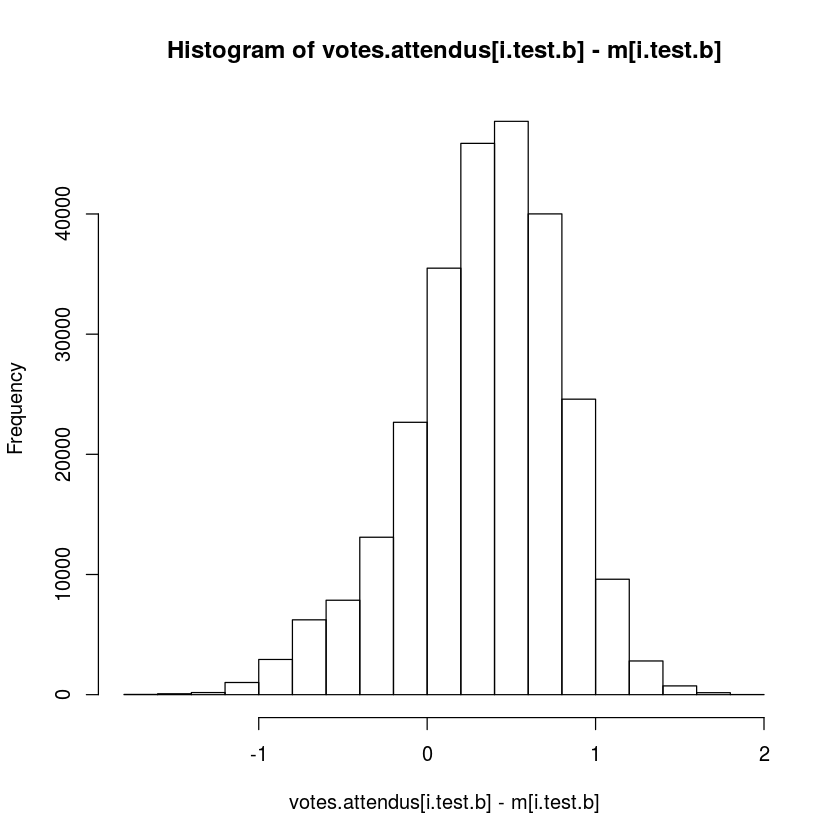

In [115]:
#############################################################################
## Avec validation croisée basée sur 10 replis (10 folds).## Le code ne fait qu'un replis.
## Le principe consiste premièrement à créer un vecteur de cellules aléatoires qui couvrent l'ensemble de la matrice.  Ce vecteur est ensuite divisé en 10 replis (sections).  Pour chaque repli, un index booléen est créé pour les données de tests et sa négation correspond aux données d'entraînement.
## Index aléatoire des données de tests
i.observed <- which(m > 0)
i.hasard <- sample(i.observed, length(i.observed))
length(i.hasard)
fold.size <- round(length(i.hasard) / 10)
i.false <- rep(FALSE, length(m))
fold.number <- 1
## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.na.train <- m.na
m.na.train[i.test.b] <- NA                # on enlève les données de test pour l'entraînement
table(m.na.train)
votes.films.moyens <- colMeans(m.na.train, na.rm=T)
mean(votes.films.moyens)                # des NaN pourraient être créés car certains films n'ont plus aucun vote## Il faudrait alors remplacer ces colonnes par une valeur correspondant à la moyenne générale.
moy.globale <- mean(m.na.train, na.rm=T)
films.sans.votes <- colSums(m.na.train, na.rm=T) == 0
sum(films.sans.votes)                   # si 0 alors pas besoin de faire l'ajustement suivant
m.na[,films.sans.votes] <- moy.globale
votes.films.moyen <- colMeans(m.na.train, na.rm=T)## fin de l'ajustement
hist(votes.films.moyens)## votes moyens des utilisateurs de test
votes.utilisateurs.moyen <- rowMeans(m.na.train, na.rm=T)## pour faire changement, utilisons la moyenne arithmétique
mean(votes.utilisateurs.moyen)          # véfication si ajustement nécessaire (ici ce ne l'est pas et on continue sans)
hist(votes.utilisateurs.moyen)
votes.attendus <- outer(votes.utilisateurs.moyen, votes.films.moyen, FUN='+') / 2## Histogramme des erreurs
hist(votes.attendus[i.test.b] - m[i.test.b])## Erreur absolue moyenne
mae(votes.attendus[i.test.b], m[i.test.b])
mean(abs(votes.attendus[i.test.b] - m[i.test.b]), na.rm=T)## Racine carrée de erreur quadratique moyenne
sqrt(mean((votes.attendus[i.test.b] - m[i.test.b])^2, na.rm=T))